In [2]:

#Loading libraries
req_packages<-c("ggplot2", "tidyverse","knitr","DT","Matrix")

for(i in c(1:length(req_packages))){
  if (!require(req_packages[i], character.only = TRUE)){
   install.packages(req_packages[i])
  }
}



Loading required package: DT

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DT’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




# Analysis of High Dimensional Data

## What is high dimensional data?
### * Capturing many data points on the same experimental unit
### * Challenge we face in "Omics" data
### - **Phenomics** - Many phenotypes measured
### - **Genomics** - Gene expression, DNA Sequencing
### - **Metabolomics** - HPCL-MS

# Problems arising in high dimensional data

## **Hypothesis testing**
### - Conducting significance tests for multiple variables
## **Visualization**
### - Clustering of samples in N-dimensional space
## **Modeling**
### - Few Observations relative to parameters (N<<P)

# Multiple testing problem
## Common Examples
### - Genome-wide association (GWAS)
### - Gene expression analysis

## * If you have 10,000 tests for which the null hypothesis is true, how many times would you reject with a cut-off of $\alpha$ < 0.05?


# Multiple Test Correction

### Let's assume we are drawing samples from the same population (null hypothesis is true). How often will we find a significant difference between samples?

[1] 502

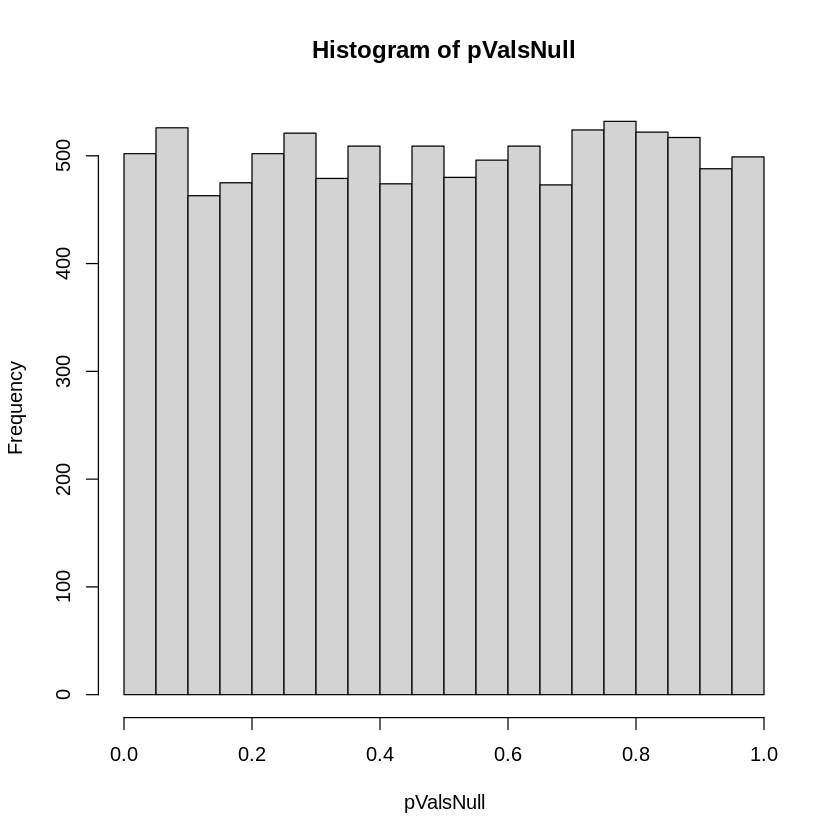

In [3]:
pValsNull <- c()
for(i in 1:10000){
  # Draw two samples from the sample distribution (standard normal)
  sample1 <- rnorm(10)
  sample2 <- rnorm(10)
  # Use a t-test to test if the two samples have statistically different means
  pVal <- t.test(sample1, sample2)$p.value
  # Save result in a vector PvalsNull
  pValsNull <- c(pValsNull, pVal)
}
# Plot distribution of p values
hist(pValsNull)
# Count how many p values are less than alpha (0.05)
sum(pValsNull < 0.05)

## How often will we find a significant difference if the samples are draw from two different populations (alternative hypothesis)?


[1] 9884

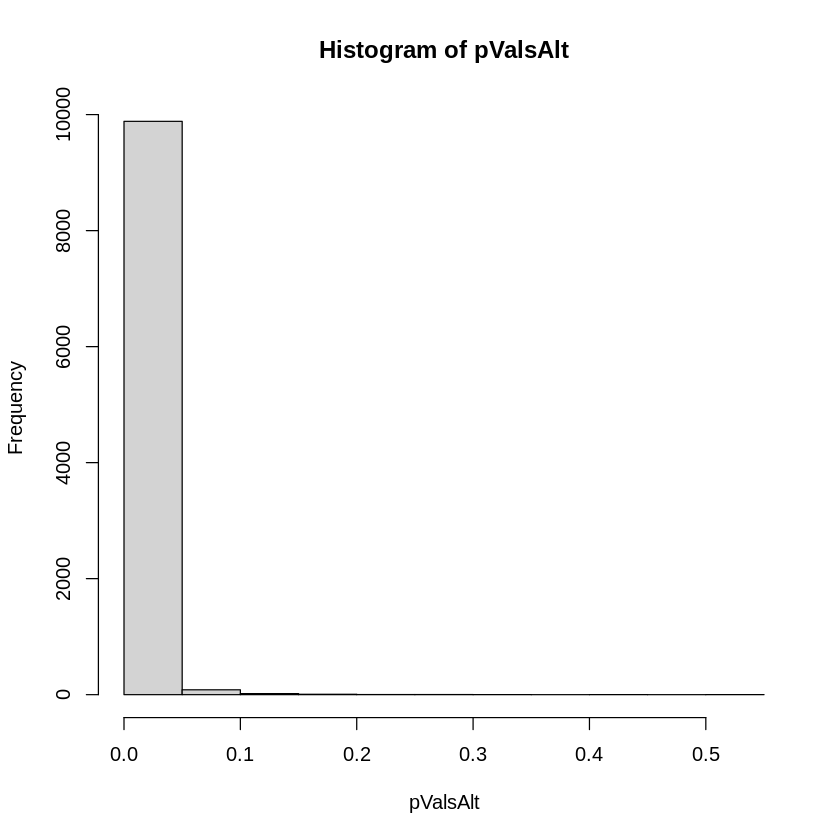

In [4]:
pValsAlt <- c()
for(i in 1:10000){
  # Draw sample one from a standard normal
  sample1 <- rnorm(10)

  # Draw sample two from a normal with a different mean
  sample2 <- rnorm(10, mean=2)
  # Use a t-test to test if the two samples have statistically different means
  pVal <- t.test(sample1, sample2)$p.value
  # Save result in a vector PvalsAlt
  pValsAlt <- c(pValsAlt, pVal)
}
# Plot distribution of p values
hist(pValsAlt)
# Count how many p values are less than alpha (0.05)
sum(pValsAlt < 0.05)

## In reality you have a mixture of null and alternative tests.

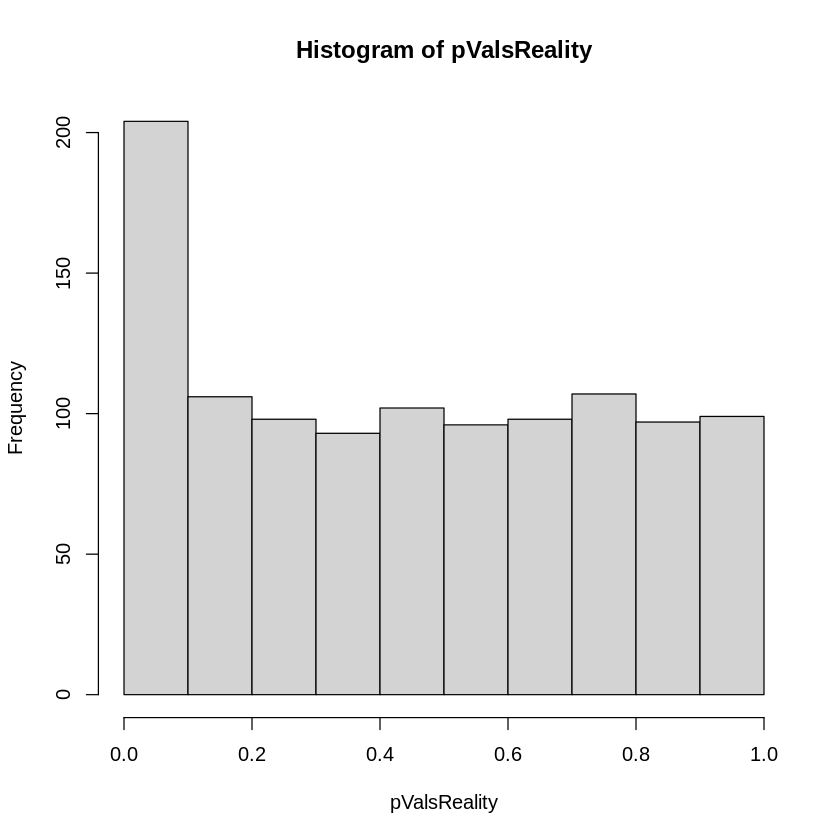

In [5]:
pValsReality <- c()
# On thousand tests null
for(i in 1:1000){
  pValsReality <- c(pValsReality,t.test(rnorm(10), rnorm(10))$p.value)
}
# One hundred tests alt
for(i in 1:100){
  pValsReality <- c(pValsReality,t.test(rnorm(10, mean=2.5), rnorm(10))$p.value)
}
hist(pValsReality)

# Controlling false positives
- ### Multiple test corrections need strike a balance between Type 1 (false positive rate) and Type 2 error (lack of power)

- ### Which type of error is worse?

|  |Null Hypothesis|  |
|------|----|-----|
|      |True|False|
|Reject|Type 1 Error| Correct|
|Accept|Correct|Type 2  Error|


## Bonferroni correction
### - $\frac{\alpha}{m}$
### - Often too conservative

## Benjamini-Hochberg correction
### - Rank p-values
### - $\frac{rank}{m}q$


## Bonferroni

In [6]:
# Multiply by m to get adjusted P values
pValsRealityAdj <- pValsReality * 1100
sum(pValsRealityAdj < 0.05)

[1] 47

In [7]:
# Using built-in R function p.adjust
sum(p.adjust(pValsReality, method="bonferroni") <  0.05)

[1] 47

## Benjamini-Hochberg correction

In [8]:
sum(p.adjust(pValsReality, method="BH") <  0.05)

[1] 103

# Visualizing data



| speed| dist|
|-----:|----:|
|     4|    2|
|     4|   10|
|     7|    4|
|     7|   22|
|     8|   16|
|     9|   10|
|    10|   18|
|    10|   26|
|    10|   34|
|    11|   17|

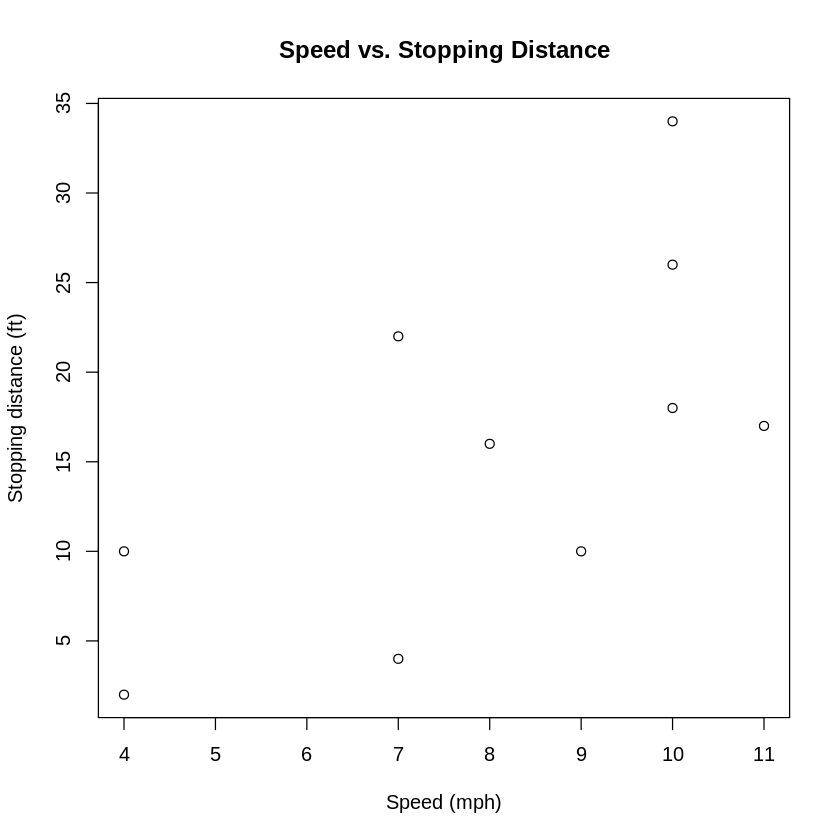

In [9]:
kable(cars[1:10,])
plot(cars[1:10,], xlab="Speed (mph)", ylab="Stopping distance (ft)", main="Speed vs. Stopping Distance")

# Visualizing high dimensional data


In [10]:
fakeGene <- data.frame(Gene1=rpois(10,3),
                       Gene2=rpois(10,4),
                       Gene3=rpois(10,4.5),
                       Gene4=rpois(10,6),
                       Gene5=rpois(10,6),
                       Gene6=rpois(10,10))
kable(fakeGene)



| Gene1| Gene2| Gene3| Gene4| Gene5| Gene6|
|-----:|-----:|-----:|-----:|-----:|-----:|
|     4|     5|     4|     4|     6|     5|
|     7|     5|     9|     7|     8|     4|
|     4|     2|     3|     7|     5|    14|
|     1|     2|     4|     7|    10|    11|
|     0|     4|     4|     7|     2|    10|
|     3|     2|     3|     6|     3|     6|
|     2|     7|     2|     3|     3|    20|
|     5|     4|     5|     8|     6|     6|
|     2|     3|     3|     4|     7|     4|
|     3|     1|     3|     4|     7|    13|

# Principal components analysis

- ### Finds combination of variables that produces a new axis (PC)
- ### Designed to maximize variance explained by each PC
- ### PCs are orthagonal to each other
- ### Useful for visualization and can be used in a regression contexts



![](https://github.com/krr73/PLSCI-7201/blob/main/Modules/Module9/Lecture/images/pca.webp?raw=1)


https://doi.org/10.1038/srep25696

# Principal components analysis

- ### $\mathbf{X}$ is a n x m incidence matrix
- ### $\mathbf{X}'\mathbf{X}$ is m x m
- ### $S.D(\mathbf{X}'\mathbf{X}) = \mathbf{U}\mathbf{D}\mathbf{U}'$
- ### $\mathbf{U}$ contains **eigenvectors**
- ### $\mathbf{D}$ is a diagonal matrix of **eigenvalues**
- ### We want the **scores** in matrix $\mathbf{T}$
 + ### $\mathbf{T} = \mathbf{X}\mathbf{U}$


## Example

In [11]:
diamSub <-diamonds[1:40, c("carat", "depth", "table",
                                  "price", "x","y","z")]
diamSubLabs <- diamonds[1:40,"price"]
diamSubScaled <- scale(diamSub)
pcaRes <- princomp(diamSubScaled)

## Make a Scree plot

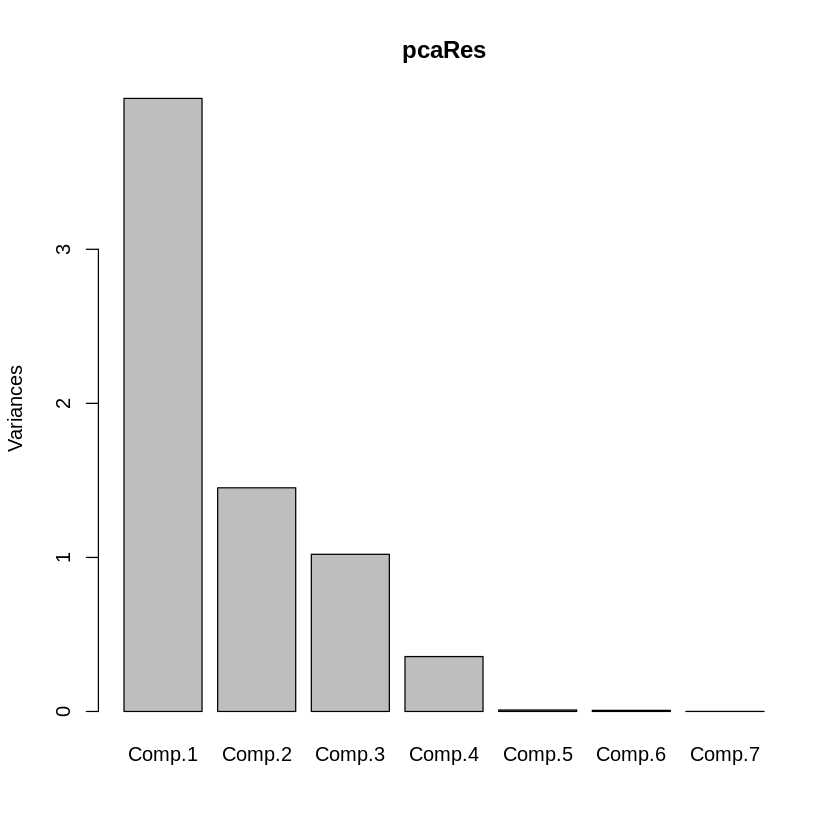

In [12]:
plot(pcaRes)

## Plot the scores

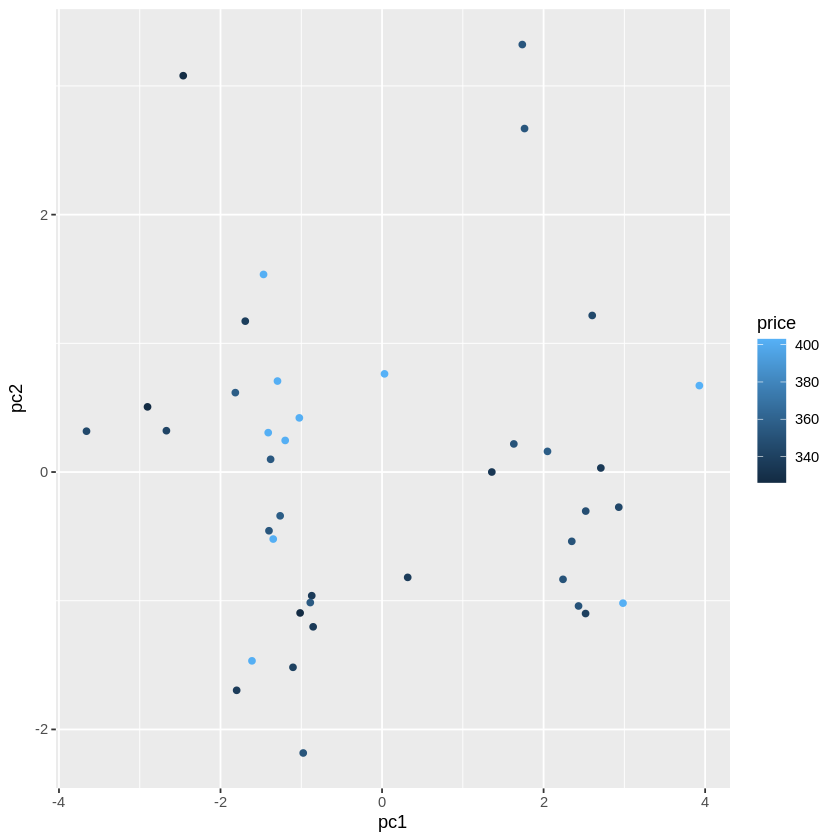

In [13]:
pcs <- data.frame(pc1=pcaRes$scores[,1],
                  pc2=pcaRes$scores[,2],
                  cut=diamSubLabs)
pca.gg <- ggplot(pcs, aes(x=pc1, y=pc2, color=price)) +
          geom_point()
pca.gg

# Analyzing high dimensional data (N<<P)

## Simulate data

The following section of code simulates multiple continuous covariates and the corresponding phenotypes. This data set will be used to explore various methods for dealing with high-dimensional data. The simulated data set is small for demonstration purposes, but is generated to show the issues that arise from over-parameterization and how various modeling approaches deal with these challenges.

In [14]:
set.seed(100)
# generate multiple continuous independent variables for 100 observations
#initializing the full incidence matrix
Xfull=matrix(0,100,70)
for(i in c(1:70)){
  Xfull[,i]=rnorm(100,0,1)
}
# Xfull now has 70 independent covariates that were generated with no correlation structure
# generate phenotypes that are a function of the randomly generated covariates
# sample beta values
betaTrue=runif(70,.1,1)
#generate phenotpyes
y=Xfull%*%betaTrue+rnorm(100,0,(.5*var(Xfull%*%betaTrue))**.5)
var(y)
var(Xfull%*%betaTrue)

24.88543


16.08086


## Creating an over-parameterized situation

The dataset as simulated is not overparameterized - the number of parameters is less than the number of independent observation used to solving for the unknown effects. we will generate an over-parameterized dataset by taking a random subset of data such that the number of independent of observations is less than the number of parameters.

## First let's get the OLS estimates for beta using the full dataset

[1] 70
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 1.554312e-14

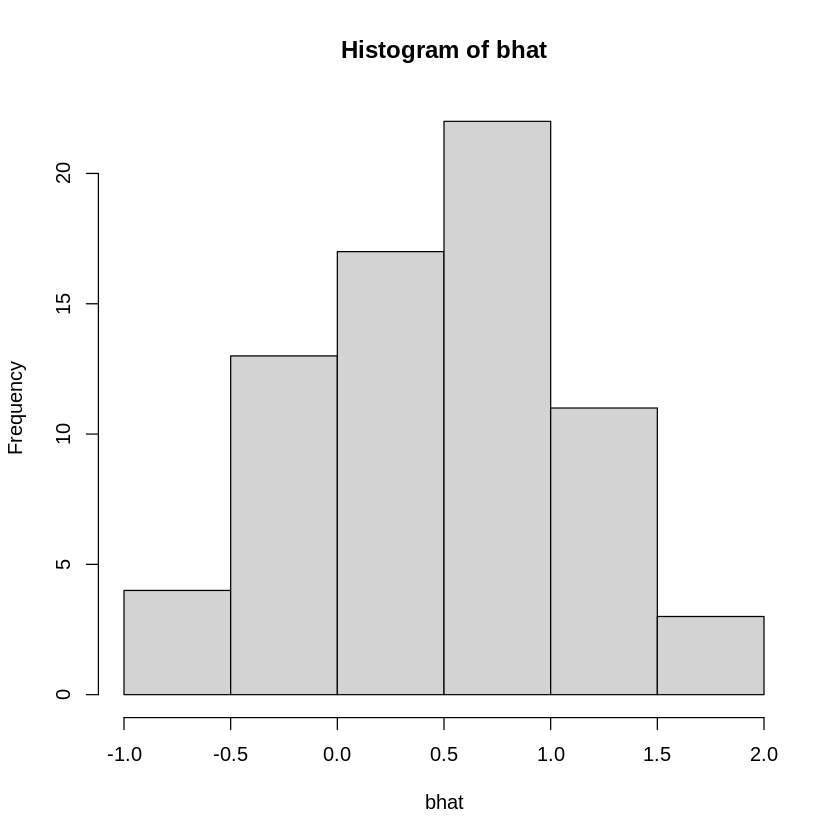

In [15]:
XfXf=t(Xfull)%*%(Xfull)
#XfXf matrix is full rank so we can invert and solve for bhat
rankMatrix(XfXf)
# solving for bhat
bhat=solve(XfXf)%*%t(Xfull)%*%y
hist(bhat)

Now let's take a subset of this data to create an over parameterized dataset-
where p > n. To do this we will create y.train which we will use to estimate bhat and y.validation that we will use to test how good the estimates are at predicting the value of observations that were not used to get the solution.
Cross-validation is a good way to examine overfitting, a common problem with over parameterized data.

In [16]:
# Create training set from initial data set
Xt=Xfull[1:30,]
y.train=y[1:30]

# Create validation set from initial data set
Xv=Xfull[31:100,]
y.validation=y[31:100]

#now let's try to solve for bhat using the reduced data set
XtXt=t(Xt)%*%(Xt)
rankMatrix(XtXt)
#bhat=solve(XtXt)%*%t(Xt)%*%y

[1] 30
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 1.554312e-14

# Ridge Regression
XtXt is a 70x70 matrix with a rank of 30 (we only have 30 observations). As a result XtXt is singular meaning we cannot invert it and we cannot get solutions for bhat. We need to find a way to solve for bhat as best we can while dealing with the issue of over-parameterization. Feature selection is one option, but in this case we know each covariate explains variation in y, so eliminating 40 of these covariates to get a full rank XtXt is not an ideal solution.

Ridge regression works by adding some constant value to the diagonal of XtXt to enable us to invert it and solve. Adding a value to the diagonal means our solutions are no longer unbiased - so not good if we are using the estimates for hypothesis testing, but bias in estimates are acceptable if the goal is prediction and introducing the bias leads to good predictors.

In [17]:
# Randomly choosing the constant to add to the diagonal. In practice you would want to find the constant that maximizes prediction accuracy (usually measure using cross-validation)
RRconstant=10
# Adding constant
RRXtXt=XtXt + diag(RRconstant,70,70)
# testing to see if it is full rank
rankMatrix(RRXtXt)

# Given RRXtXt is full rank let's go ahead and solve for bhat
bhatRR=solve(RRXtXt)%*%t(Xt)%*%y.train

# generating predicted yhat values for the 70 obseervation we left out of the training dataset
yhatv=Xv%*%bhatRR

# calculating the correlation
cor(yhatv,y.validation)

[1] 70
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 1.554312e-14

0.3564347


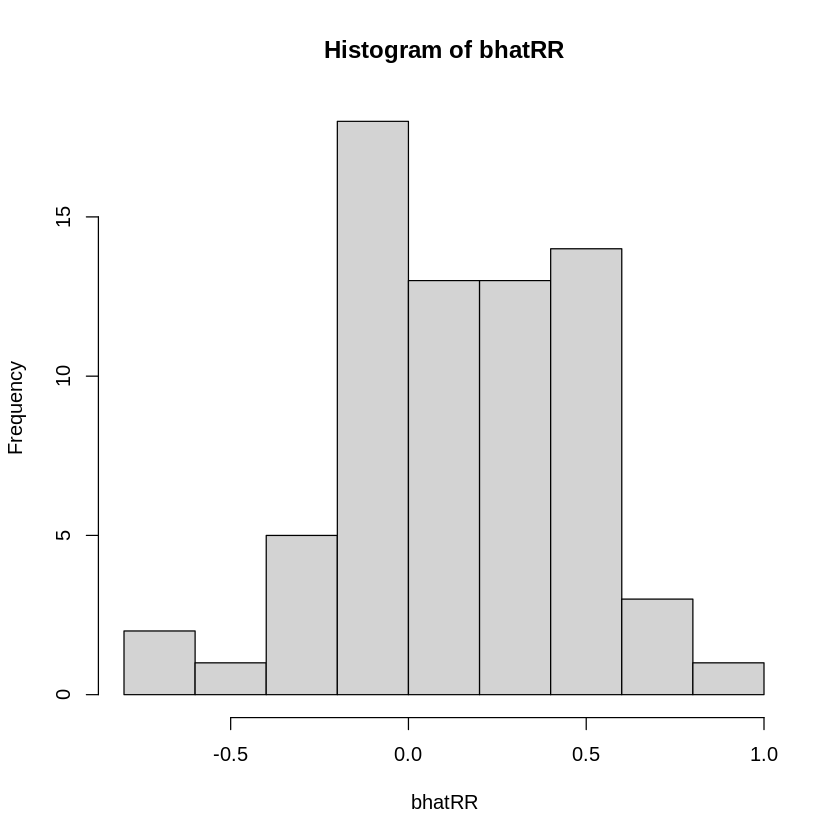

In [18]:
hist(bhatRR)

0.3705643


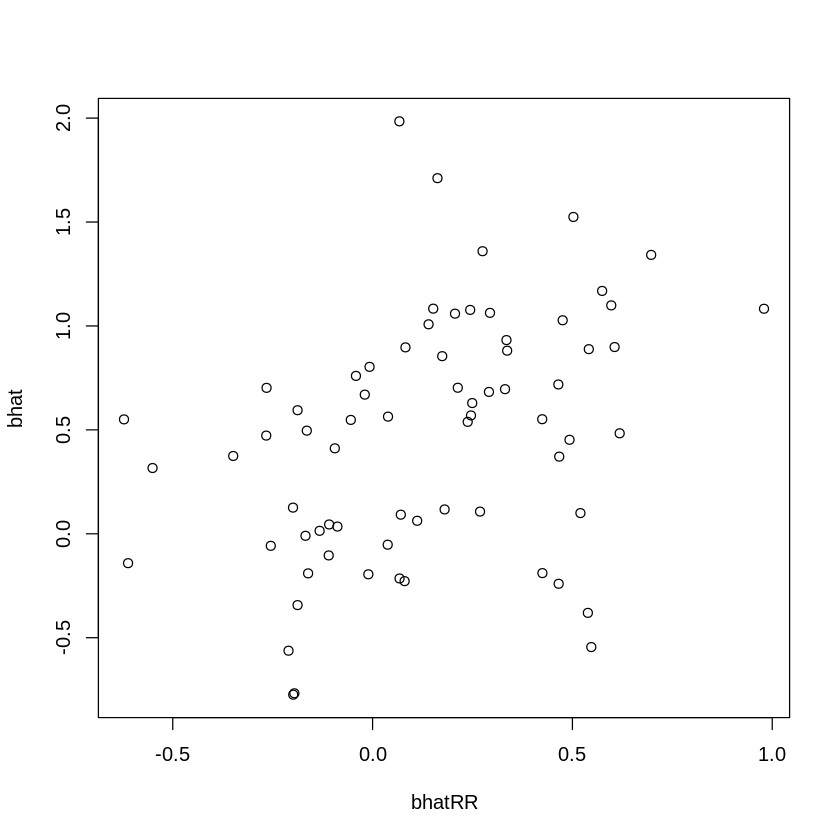

In [19]:
cor(bhatRR,bhat)
plot(bhatRR,bhat)

## Principle Component Regression

Unlike penalized methods that fit all covariates but use a penalty to prevent overfitting, PCR seeks to reduce the dimensions of the data. Rather than removing the columns of X as would be done using feature selection, PCR decomposes X into orthogonal components and retains components that explain the majority of variation in X.

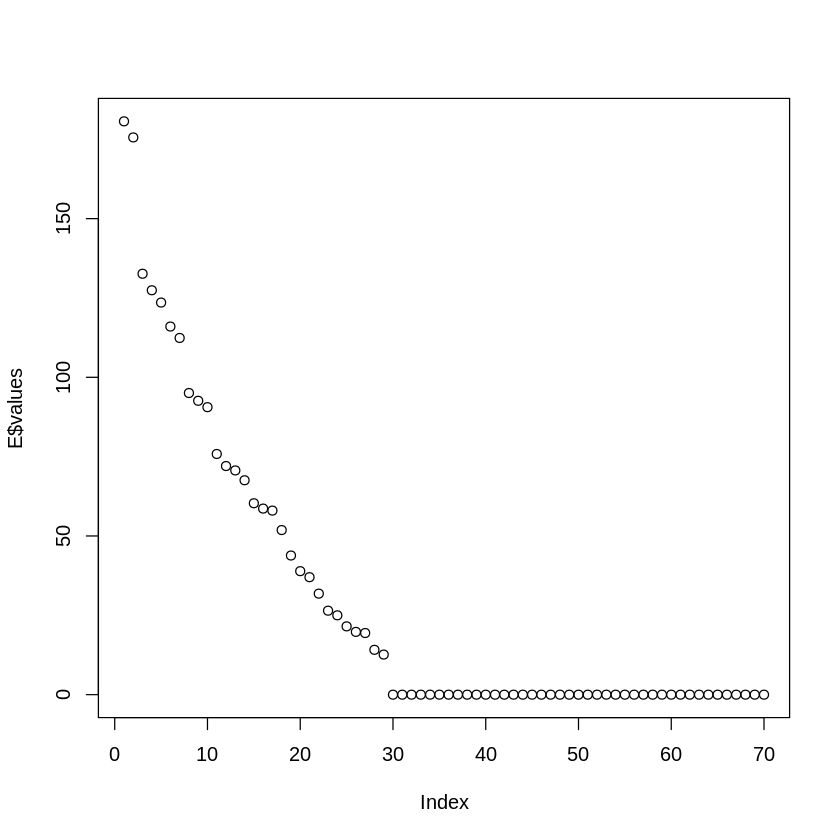

In [20]:
#In this example we will use a spectral decomposition of X'X to form a matrix T wich contains orthagonal vectors (columns)
#first let's center X - given the values in X were simulated to have a mean of zero this won't have much of an impact but it is best pratice to do so.
Xtc=scale(Xt, center=TRUE, scale=F)
# Here we use the function eigen to decompose X'X
XtcXtc=t(Xtc)%*%Xtc
E=eigen(XtcXtc)
# E is an object that contains both the eigen values and the eigen vectors
# Lets plot the eigen values
plot(E$values)

Since Xtc'Xtc in this case has a rank of 30, the first 30 eigenvectors explain all of the variation in Xtc. Our next step is to construct a full rank matrix with orthogonal columns (T) and the solve for OLS using T.

In [21]:
# First let's pull the eigen vectors out of the object E
U=E$vectors
# We now want to set up P such that T'T can be inverted. For starters let's take the first 29 vectors in U
P=U[,1:29]
# Now we calculate T as T=XP
T=Xtc%*%P
# Solving OLS using T
bpcr=solve(t(T)%*%T)%*%t(T)%*%y.train
# Now let's do cross validation to see how good our predictor is
Xvc=scale(Xv, center=TRUE, scale=F)
Tv=Xvc%*%P
yhatvpcr=Tv%*%bpcr
cor(yhatvpcr,y.validation)

0.3728566


## Ridge regression is a penalized method
- ### Random effects in a mixed model are also a penalized method and can be used to prevent overfitting
- ### When working with high-dimensional data penalized methods are commonly used
    - ### Methods differ based on the type of penalty and how it is estimated
    - ### For mixed models the penalty is:     
$\frac{\sigma^2_{e}}{\sigma^2_{u}}$
- ### Genomic prediction is a common breeding application for penalized methods
